# Sales Forecasting for SmallBasket

Problem description: Small Basket is a huge online / mobile application based grocery retailer in India,
founded in 2011. Small Basket is trying to manage its supply chain and delivery
partners and would like to accurately forecast the sales for the period starting
from 1st January 2019 to 15th January 2019 . You are also given a few features
that were developed by the Business Intelligence team, that might or might not
provide additional insights to your analysis.

**Objectives:**
1. Explore the data and engineer new features
2. Predict the number of sales for a given item for the dates given in the
‘test.csv’ file
3. Business units belonging to which cluster will see the highest amount of
sales for the first 15 days of 2019?
4. What are the top 10 selling items in this cluster?
5. What is the rate of purchase per week for these items?

In [0]:
import os, sys
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline  

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [0]:
import datetime
from datetime import date
import statsmodels.api as sm

In [0]:
import plotly.graph_objs as go
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot, plot
from pandas import read_csv

In [3]:
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import LSTM

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
os.getcwd()

'/content'

In [8]:
PATH = "/content/drive/My Drive/Insofe"
os.chdir(PATH)
os.getcwd()

'/content/drive/My Drive/Insofe'

Function defination

In [0]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

**1. Reading item_details.csv and performing analysis on it.**

In [0]:
item_details = pd.read_csv("item_details.csv")

In [8]:
print(item_details.shape)
print(item_details.dtypes)

(4100, 4)
item_id             object
category_of_item    object
class               object
perishable           int64
dtype: object


1.1 Distribution of various categories of items

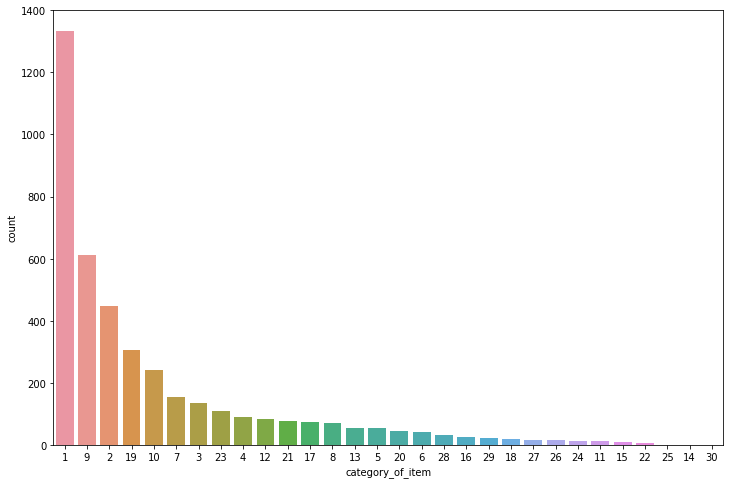

In [21]:

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.countplot( data = item_details, x = "category_of_item",order = item_details['category_of_item'].value_counts().index)

Inference:
Most of the unique item id belong to the below categories:
- Grocery Items
- Beverages
- Cleaning


1.2 Distribution of perishable goods by category

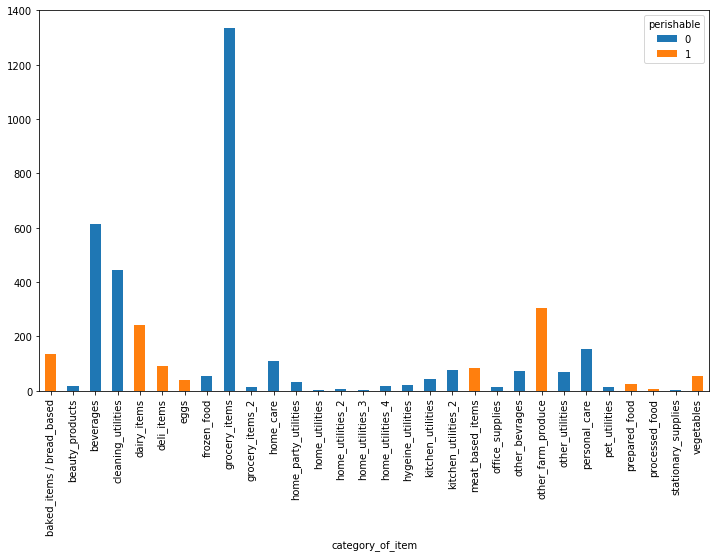

In [0]:
ct = pd.crosstab(item_details.category_of_item, item_details.perishable)
ct.plot.bar(figsize = (12, 7), stacked=True)
plt.legend(title='perishable')
plt.show()

Inference: Farm products, dairy items, bakery items consists of perishable items.

1.3 Distrbution of number of unique classes per family of items.

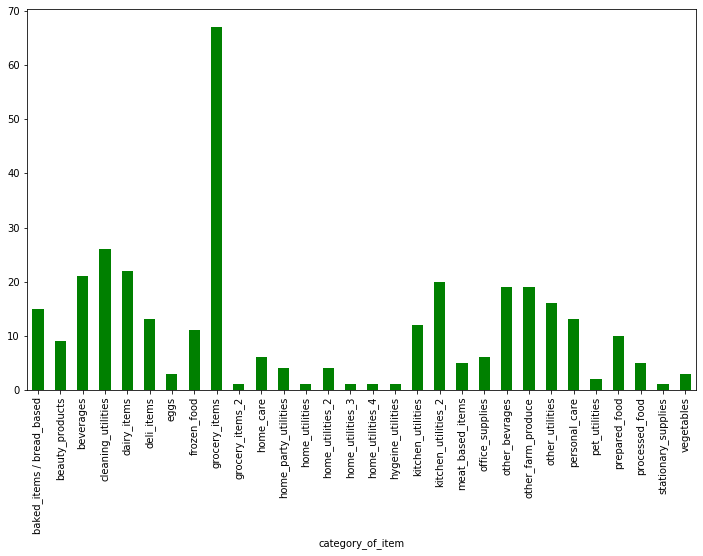

In [0]:
xc = item_details.groupby(['category_of_item'])['class'].nunique()
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
xc.plot.bar(color='green')
plt.show()

Inference:Grocery I family has the most number of classes of items present. category_of_item is further devided into classes.

In [0]:
pickle_out = open("item_details.pickle","wb")
pickle.dump(item_details, pickle_out)
pickle_out.close()

In [0]:
pickle_in = open("item_details.pickle","rb")
item_details = pickle.load(pickle_in)

In [9]:
print(item_details['item_id'].memory_usage(deep=True))
print(item_details['category_of_item'].memory_usage(deep=True))
print(item_details['class'].memory_usage(deep=True))

281644
289805
274828


In [0]:
item_details.dtypes

item_id             object
category_of_item    object
class               object
perishable           int64
dtype: object

In [0]:
item_details.isnull().sum()

item_id             0
category_of_item    0
class               0
perishable          0
dtype: int64

Optimization to reduce the memory

In [0]:
itemid_unique = item_details['item_id'].unique()
category_unique = item_details['category_of_item'].unique()
class_unique = item_details['class'].unique()

In [0]:
itemid_mapping = {item_details: idx for 
                             idx, item_details in 
                             enumerate(itemid_unique, 1)}
item_details['item_id'] = item_details['item_id'].map(itemid_mapping)

In [0]:
category_mapping = {item_details: idx for 
                             idx, item_details in 
                             enumerate(category_unique, 1)}
item_details['category_of_item'] = item_details['category_of_item'].map(category_mapping)

In [0]:
class_mapping = {item_details: idx for 
                             idx, item_details in 
                             enumerate(class_unique, 1)}
item_details['class'] = item_details['class'].map(class_mapping)

In [14]:
print(item_details['item_id'].memory_usage(deep=True))
print(item_details['category_of_item'].memory_usage(deep=True))
print(item_details['class'].memory_usage(deep=True))

32928
32928
32928


Memory size is reduced from 281644, 289805, 274828 to 32928, 32928, 32928.

In [0]:
item_details.dtypes

item_id             int64
category_of_item    int64
class               int64
perishable          int64
dtype: object

In [0]:
item_details.head

<bound method NDFrame.head of       item_id  category_of_item  class  perishable
0           1                 1      1           0
1           2                 1      2           0
2           3                 2      3           0
3           4                 1      4           0
4           5                 3      5           1
...       ...               ...    ...         ...
4095     4096                 1     77           0
4096     4097                 1     38           0
4097     4098                 1    318           0
4098     4099                 9     48           0
4099     4100                17    174           0

[4100 rows x 4 columns]>

In [0]:
pickle_out = open("item_details_memory.pickle","wb")
pickle.dump(item_details, pickle_out)
pickle_out.close()

**2. Reading location_details.csv and performing analysis on it.**

In [0]:
location_details = pd.read_csv("location_details.csv")

In [0]:
location_details.isnull().sum()

location_id    0
city           0
state          0
type           0
cluster        0
dtype: int64

In [0]:
location_details.shape

(54, 5)

In [0]:
location_details.dtypes

location_id    object
city           object
state          object
type           object
cluster         int64
dtype: object

2.1 Distribution of stores across cities

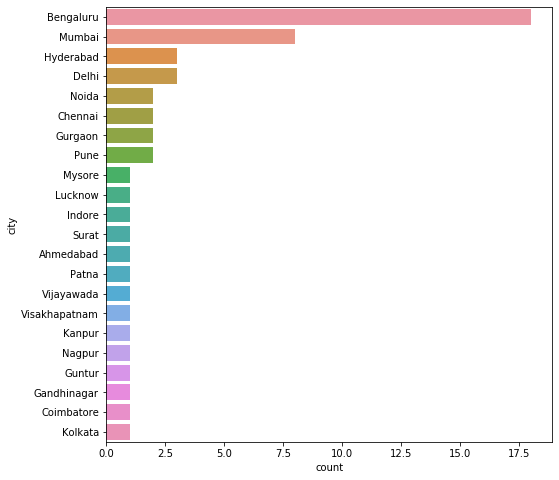

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=location_details['city'], data=location_details, order = location_details['city'].value_counts().index)

Inference : Bangalore and Mumbai has got maximum number of stores.

2.2 Distribution of store across states

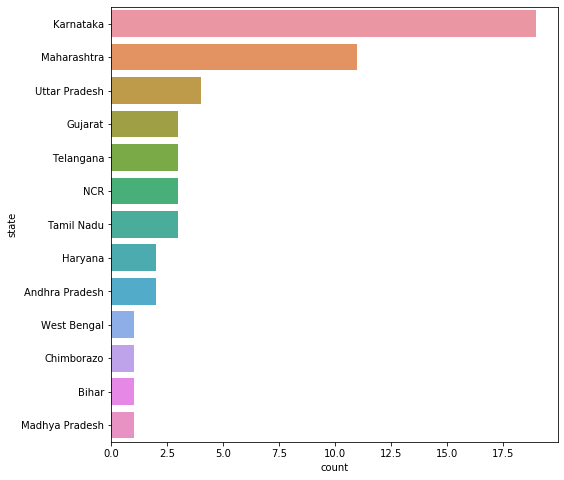

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=location_details['state'], data=location_details, order = location_details['state'].value_counts().index)

Inference: Karnataka has got maximum number of stores followed by Maharashtra. Least number of stores are present in Bihar.

2.3 Store distribution based on type.

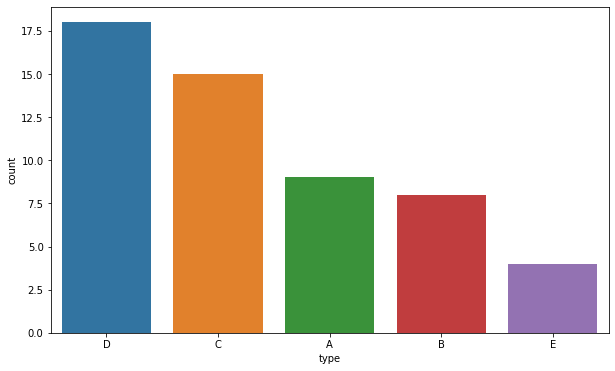

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax = sns.countplot(x="type", data=location_details, order = location_details['type'].value_counts().index)

Inference: Class D and C has large number of stores compared to rest of the types.

2.4 Types of stores across states

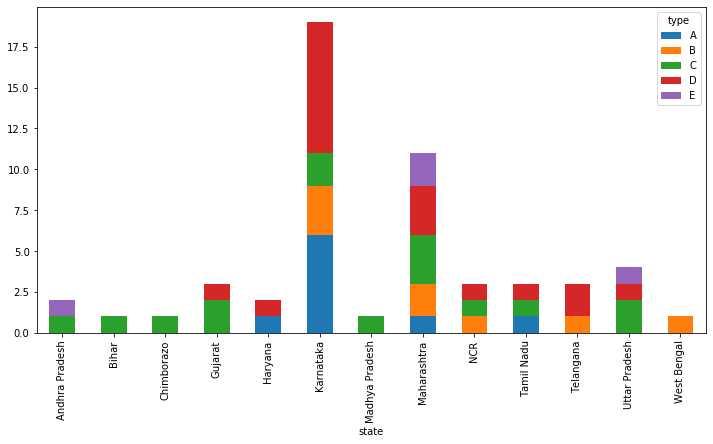

In [0]:
ct = pd.crosstab(location_details.state, location_details.type)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.legend(title='type')
plt.show()

2.5 Distribution of Clusters in type

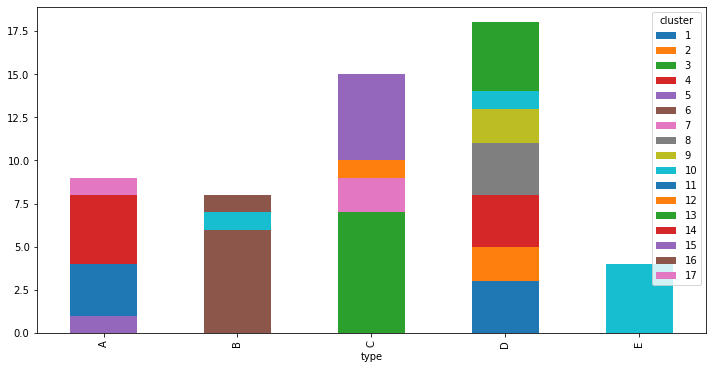

In [0]:
ct = pd.crosstab(location_details.type, location_details.cluster)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.legend(title='cluster')
plt.show()

2.5 Distribution of Types in Cluster

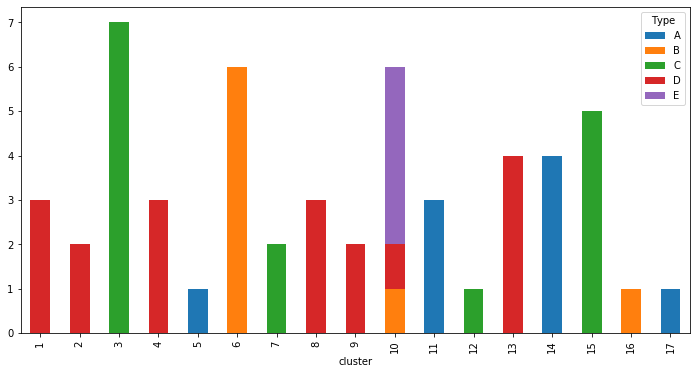

In [0]:
ct = pd.crosstab(location_details.cluster, location_details.type)
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.legend(title='Type')
plt.show()

From the above graph, each cluster is mapped to only one type. Except for cluster 10.

In [0]:
pickle_out = open("location_details.pickle","wb")
pickle.dump(location_details, pickle_out)
pickle_out.close()

In [0]:
pickle_in = open("location_details.pickle","rb")
location_details = pickle.load(pickle_in)

In [26]:
print(location_details['location_id'].memory_usage(deep=True))
print(location_details['city'].memory_usage(deep=True))
print(location_details['state'].memory_usage(deep=True))
print(location_details['type'].memory_usage(deep=True))

3791
5447
5987
3692


Memory optimization

In [0]:
loc_unique = location_details['location_id'].unique()
city_unique = location_details['city'].unique()
state_unique = location_details['state'].unique()
type_unique = location_details['type'].unique()

In [0]:
loc_mapping = {location_id: idx for 
                             idx, location_id in 
                             enumerate(loc_unique, 1)}
location_details['location_id'] = location_details['location_id'].map(loc_mapping)

In [0]:
city_mapping = {city: idx for 
                             idx, city in 
                             enumerate(city_unique, 1)}
location_details['city'] = location_details['city'].map(city_mapping)

In [0]:
state_mapping = {state: idx for 
                             idx, state in 
                             enumerate(state_unique, 1)}
location_details['state'] = location_details['state'].map(state_mapping)

In [0]:
type_mapping = {state: idx for 
                             idx, state in 
                             enumerate(type_unique, 1)}
location_details['type'] = location_details['type'].map(type_mapping)

In [35]:
print(location_details['location_id'].memory_usage(deep=True))
print(location_details['city'].memory_usage(deep=True))
print(location_details['state'].memory_usage(deep=True))
print(location_details['type'].memory_usage(deep=True))

560
560
560
560


In [0]:
pickle_out = open("location_details_memory.pickle","wb")
pickle.dump(location_details, pickle_out)
pickle_out.close()

**3. Reading train_transactions.csv and performing analysis on it.**

In [0]:
train_transactions = pd.read_csv("train_transactions.csv")

In [0]:
train_transactions.isnull().sum()

date                   0
location_identifier    0
transactions           0
dtype: int64

In [0]:
train_transactions.shape

(71391, 3)

In [0]:
train_transactions.dtypes

date                   object
location_identifier    object
transactions            int64
dtype: object

3.1 Distribution of total number of transactions made per individual store

[Text(0, 0, 'location_1'),
 Text(0, 0, 'location_10'),
 Text(0, 0, 'location_11'),
 Text(0, 0, 'location_12'),
 Text(0, 0, 'location_13'),
 Text(0, 0, 'location_14'),
 Text(0, 0, 'location_15'),
 Text(0, 0, 'location_16'),
 Text(0, 0, 'location_17'),
 Text(0, 0, 'location_18'),
 Text(0, 0, 'location_19'),
 Text(0, 0, 'location_2'),
 Text(0, 0, 'location_20'),
 Text(0, 0, 'location_21'),
 Text(0, 0, 'location_22'),
 Text(0, 0, 'location_23'),
 Text(0, 0, 'location_24'),
 Text(0, 0, 'location_25'),
 Text(0, 0, 'location_26'),
 Text(0, 0, 'location_27'),
 Text(0, 0, 'location_28'),
 Text(0, 0, 'location_29'),
 Text(0, 0, 'location_3'),
 Text(0, 0, 'location_30'),
 Text(0, 0, 'location_31'),
 Text(0, 0, 'location_32'),
 Text(0, 0, 'location_33'),
 Text(0, 0, 'location_34'),
 Text(0, 0, 'location_35'),
 Text(0, 0, 'location_36'),
 Text(0, 0, 'location_37'),
 Text(0, 0, 'location_38'),
 Text(0, 0, 'location_39'),
 Text(0, 0, 'location_4'),
 Text(0, 0, 'location_40'),
 Text(0, 0, 'location_41

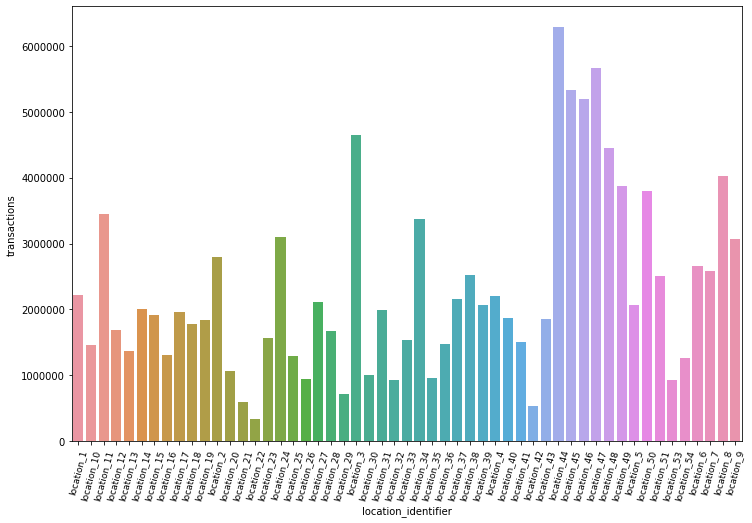

In [48]:
pc = (train_transactions.groupby(['location_identifier']).sum())
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x = pc.index, y= "transactions", data = pc)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize = 9)
#ax.set_xticklabels(rotation = 75, fontsize = 9)

Inference - Store 44 has the highest transations.

image.png

In [0]:
pickle_out = open("train_transactions.pickle","wb")
pickle.dump(train_transactions, pickle_out)
pickle_out.close()

In [22]:
print(train_transactions['date'].memory_usage(deep=True))
print(train_transactions['location_identifier'].memory_usage(deep=True))
print(train_transactions['transactions'].memory_usage(deep=True))

4783325
571256
571256


In [0]:

loc_unique = train_transactions['location_identifier'].unique()
transactions_unique = train_transactions['transactions'].unique()

In [0]:
loc_mapping = {train_transactions: idx for 
                             idx, train_transactions in 
                             enumerate(loc_unique, 1)}
train_transactions['location_identifier'] = train_transactions['location_identifier'].map(loc_mapping)

In [0]:
trans_mapping = {train_transactions: idx for 
                             idx, train_transactions in 
                             enumerate(transactions_unique, 1)}
train_transactions['transactions'] = train_transactions['transactions'].map(trans_mapping)

In [62]:
print(train_transactions['date'].memory_usage(deep=True))
print(train_transactions['location_identifier'].memory_usage(deep=True))
print(train_transactions['transactions'].memory_usage(deep=True))

4783325
571256
571256


In [0]:
pickle_out = open("train_transactions_memory.pickle","wb")
pickle.dump(item_details, pickle_out)
pickle_out.close()

Memory optimization is done and file has been pickled for future use

# **4. Reading train.csv file and performing analysis.**

In [26]:
train = pd.read_csv("train.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



In [64]:
train.isnull().sum()

date                  0
locationId            0
item_id               0
unit_sales            0
onpromotion    21657651
dtype: int64

In [65]:
train.shape

(101688779, 5)

In [66]:
train.head()

,date,locationId,item_id,unit_sales,onpromotion
0,2015-01-01,location_25,item_103665,7.0,NaN
1,2015-01-01,location_25,item_105574,1.0,NaN
2,2015-01-01,location_25,item_105575,2.0,NaN
3,2015-01-01,location_25,item_108079,1.0,NaN
4,2015-01-01,location_25,item_108701,1.0,NaN


In [0]:
pickle_out = open("train.pickle","wb")
pickle.dump(train, pickle_out)
pickle_out.close()

In [0]:
pickle_in = open("train.pickle","rb")
train = pickle.load(pickle_in)

In [68]:
train.dtypes

date            object
locationId      object
item_id         object
unit_sales     float64
onpromotion     object
dtype: object

In [0]:
train['onpromotion'].fillna("Unknown", inplace = True) 

In [70]:
print(train['locationId'].memory_usage(deep=True))
print(train['item_id'].memory_usage(deep=True))
print(train['unit_sales'].memory_usage(deep=True))
print(train['onpromotion'].memory_usage(deep=True))

6893011537
6961168750
813510360
3967329780


Memory optimization

In [0]:
train_loc_unique = train['locationId'].unique()
train_item_unique = train['item_id'].unique()
train_onpromotion_unique = train['onpromotion'].unique()

In [0]:
train_onpromotion_unique

array(['Unknown', False, True], dtype=object)

In [0]:
len(train['unit_sales'].unique())

244090

In [72]:
train['unit_sales'].min()

-15372.0

In [73]:
train['unit_sales'].max()

89440.0

In [0]:
train_loc_mapping = {train: idx for 
                             idx, train in 
                             enumerate(train_loc_unique, 1)}
train['locationId'] = train['locationId'].map(train_loc_mapping)

In [0]:
train_item_id_mapping = {train: idx for 
                             idx, train in 
                             enumerate(train_item_unique, 1)}
train['item_id'] = train['item_id'].map(train_item_id_mapping)

In [0]:
train_onpromotion_mapping = {train: idx for 
                             idx, train in 
                             enumerate(train_onpromotion_unique, 1)}
train['onpromotion'] = train['onpromotion'].map(train_onpromotion_mapping)

In [0]:
train['unit_sales'] = train['unit_sales'].astype("int32")

In [78]:
print(train['locationId'].memory_usage(deep=True))
print(train['item_id'].memory_usage(deep=True))
print(train['unit_sales'].memory_usage(deep=True))
print(train['onpromotion'].memory_usage(deep=True))

813510360
813510360
406755244
813510360


In [79]:
train.dtypes

date           object
locationId      int64
item_id         int64
unit_sales      int32
onpromotion     int64
dtype: object

In [0]:
pickle_out = open("train_memory.pickle","wb")
pickle.dump(train, pickle_out)
pickle_out.close()

In [0]:
pickle_in = open("train_memory.pickle","rb")
train_data = pickle.load(pickle_in)

In [0]:
train_data.dtypes

In [35]:
train_data.sort_values(by='date', ascending=True)

,date,locationId,item_id,unit_sales,onpromotion
0,2015-01-01,1,1,7,1
382,2015-01-01,1,383,1,1
383,2015-01-01,1,384,1,1
384,2015-01-01,1,385,2,1
385,2015-01-01,1,386,2,1
...,...,...,...,...,...
101615241,2018-12-31,20,528,2,2
101615240,2018-12-31,20,1078,5,2
101615239,2018-12-31,20,1246,2,2
101615237,2018-12-31,20,526,31,2


4.1 Time span of the data collect in train.csv.

In [0]:
train_data["date"] =  pd.to_datetime(train_data["date"])

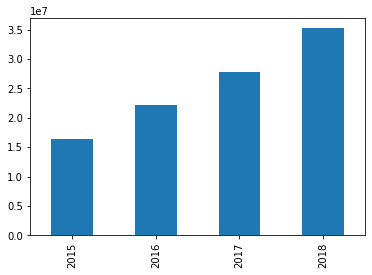

In [83]:
train_data["date"].dt.year.value_counts(sort = False).plot.bar()

They have collected data from 2015 to 2018. There is an increase in the number of observations for each year. Year 2018 has got more number of data. 


#### 4.2 Data distribution by month

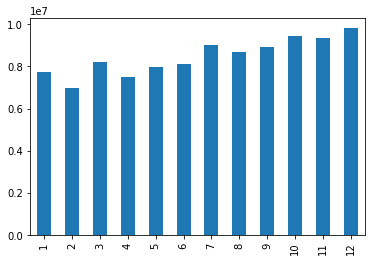

In [84]:
train_data["date"].dt.month.value_counts(sort = False).plot.bar()

The observations are almost uniformly distributed by month. The maximum occurs in December and the minimum in February and April. 

####4.3 Data distribution by days of the month.

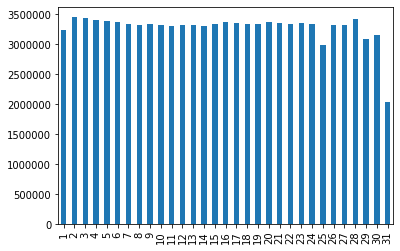

In [85]:
train_data["date"].dt.day.value_counts(sort = False).plot.bar()

The observations are almost uniformly distributed by days. The minimum occurs on 31st of every month.

4.4 Data distribution by week.

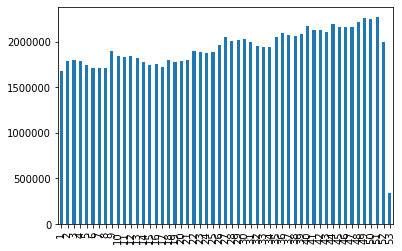

In [86]:
train_data["date"].dt.week.value_counts(sort = False).plot.bar()

There is a increase in the trend. Miminum observations occurs on last week of the year.

####4.5 Distribution by Location

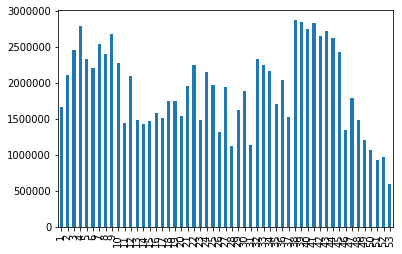

In [103]:
train_data["locationId"].value_counts(sort = False).plot.bar()

The y-axis is the number of observations corresponding to a particular store. A store with more observations does not necessarily outperform a store with fewer observations. This is because some stores may offer a wider range of products but push less volume. This would inflate their numbers in this plot. We can interpret the y-axis as a measure of the store's variety.

4.6 Analysis on Unit sales

In [104]:
train_data["unit_sales"].describe()

count    1.016888e+08
mean     8.615465e+00
std      2.348383e+01
min     -1.537200e+04
25%      2.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      8.944000e+04
Name: unit_sales, dtype: float64

Suprisingly Minimun unit sale is -1.537200e+04 which means large number of items were returned.

In [0]:
negative_sales = train_data[train_data["unit_sales"]<0].groupby('date').unit_sales.sum().reset_index() 

In [106]:
negative_sales

,date,unit_sales
0,2015-01-02,-3
1,2015-01-03,-58
2,2015-01-04,-12
3,2015-01-05,-7
4,2015-01-07,-1
...,...,...
1342,2018-12-27,-132
1343,2018-12-28,-28
1344,2018-12-29,-53
1345,2018-12-30,-14


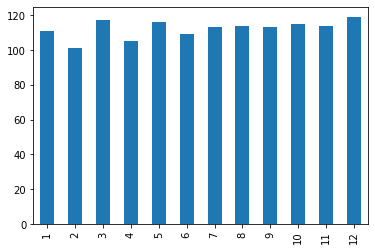

In [107]:
negative_sales["date"].dt.month.value_counts(sort = False).plot.bar()

Inference: Every month there is a constant number of item return.

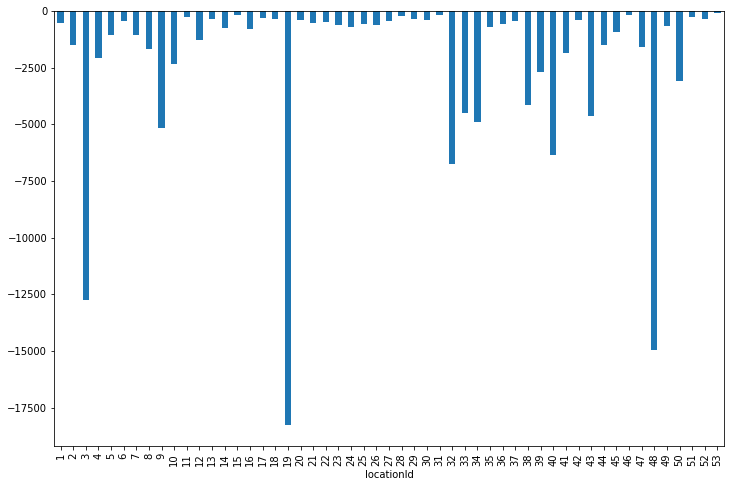

In [119]:
train_data[train_data["unit_sales"]<0].groupby('locationId').unit_sales.sum().plot.bar(figsize = (12, 8))

Location 19 has got the maximum no. of item returns.

Due to the Google collab RAM constraints, data is splited based on the year to carry out prediction. 

In [0]:
train_2017_18 = train_data[train_data["date"].dt.year > 2016]

In [0]:
train_2017_18["unit_sales"].describe()

count    6.309452e+07
mean     8.358564e+00
std      2.523590e+01
min     -1.537200e+04
25%      2.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      8.944000e+04
Name: unit_sales, dtype: float64

In [0]:
train_2018 = train_data[train_data["date"].dt.year > 2017]

In [122]:
train_2018["unit_sales"].describe()

count    3.522987e+07
mean     8.158324e+00
std      2.872297e+01
min     -4.673000e+03
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      8.944000e+04
Name: unit_sales, dtype: float64

In [0]:
time_unit_sale = train_2018.groupby('date').unit_sales.sum().reset_index() 

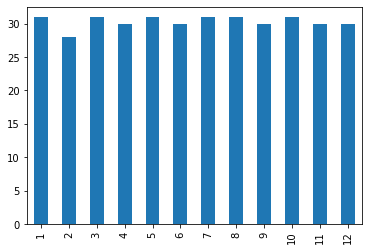

In [124]:
time_unit_sale["date"].dt.month.value_counts(sort = False).plot.bar()

In [0]:
del(train_2018) # to free memory

Impact of promotion on the unit sales

In [0]:
promotion_data = train_2017_18.groupby('onpromotion').unit_sales.sum()

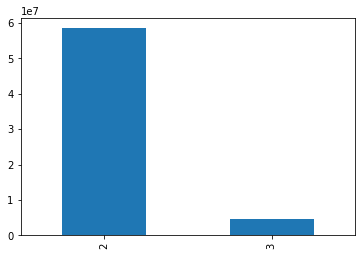

In [126]:
train_2017_18["onpromotion"].value_counts(sort = False).plot.bar()

In [127]:
print(train_2017_18['onpromotion'].unique())

[2 3]


In [128]:
print(train_2017_18["onpromotion"].value_counts)

<bound method IndexOpsMixin.value_counts of 38594264     2
38594265     2
38594266     2
38594267     2
38594268     2
            ..
101688774    3
101688775    2
101688776    2
101688777    2
101688778    2
Name: onpromotion, Length: 63094515, dtype: int64>


In [133]:
promotion_data


onpromotion
2    468060375
3     59319176
Name: unit_sales, dtype: int32

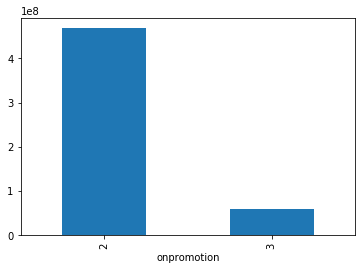

In [134]:
promotion_data.plot.bar()

Stores distribution across cities

In [137]:
train_2017_18.shape

(63094515, 5)

In [138]:
train_2017_18.dtypes

date           datetime64[ns]
locationId              int64
item_id                 int64
unit_sales              int32
onpromotion             int64
dtype: object

In [139]:
train_2017_18.head

<bound method NDFrame.head of                 date  locationId  item_id  unit_sales  onpromotion
38594264  2017-01-01           1        1          12            2
38594265  2017-01-01           1        3          23            2
38594266  2017-01-01           1     1790           1            2
38594267  2017-01-01           1      584           6            2
38594268  2017-01-01           1        6           6            2
...              ...         ...      ...         ...          ...
101688774 2018-12-31          46     3805           6            3
101688775 2018-12-31          46     3863           4            2
101688776 2018-12-31          46     3849          10            2
101688777 2018-12-31          46     3807           3            2
101688778 2018-12-31          46     3864           1            2

[63094515 rows x 5 columns]>

In [0]:
test_2015_16 = train_data[train_data["date"].dt.year < 2017]

In [141]:
test_2015_16.shape

(38594264, 5)

In [142]:
test_2015_16.dtypes

date           datetime64[ns]
locationId              int64
item_id                 int64
unit_sales              int32
onpromotion             int64
dtype: object

In [0]:
split = (38594264/(63094515 + 38594264))*100

In [144]:
split

37.95331636345048

In [0]:
train_2017_18.to_csv("train_2017_18.csv")
test_2015_16.to_csv("test_2015_16.csv")

In [0]:
pickle_in = open("item_details_memory.pickle","rb")
item_data = pickle.load(pickle_in)

In [0]:
train_sale = test_2015_16.groupby('date').unit_sales.sum().reset_index()

In [34]:
train_sale.shape

(728, 2)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



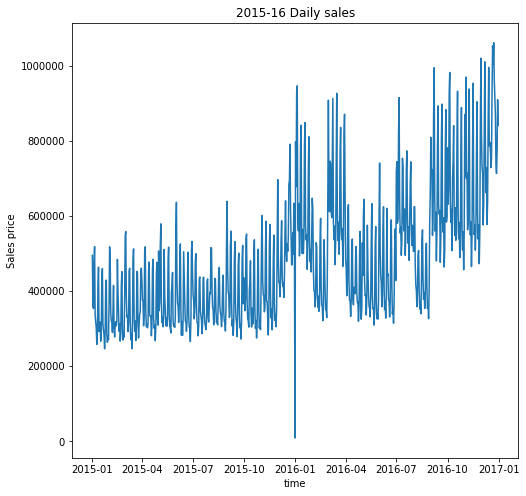

In [35]:
ts=train_sale.loc[1:728].set_index('date')
plt.figure(figsize=(8,8))
#fig, ax = plt.subplots()
plt.title('2015-16 Daily sales')
plt.xlabel('time')
plt.ylabel('Sales price')
#train_sales1.plot(x = 'date', y='unit_sales',ax=ax,legend=None)
plt.plot(ts);

In [0]:
train_sale1 = train_2017_18.groupby('date').unit_sales.sum().reset_index()

In [147]:
train_sale1.shape

(728, 2)

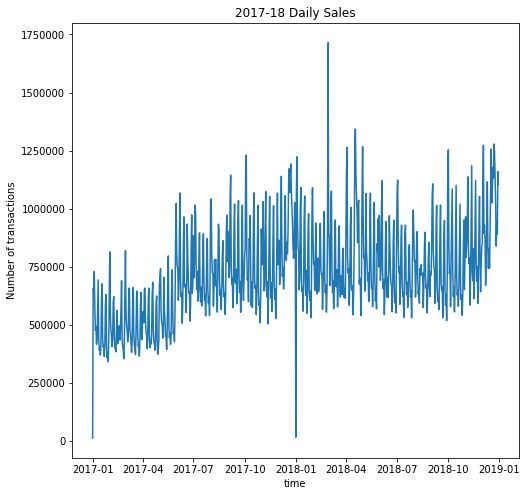

In [148]:
ts=train_sale1.loc[0:728].set_index('date')
plt.figure(figsize=(8,8))
#fig, ax = plt.subplots()
plt.title('2017-18 Daily Sales')
plt.xlabel('time')
plt.ylabel('Number of transactions')
plt.plot(ts);

In [0]:
full_data = train_data.groupby('date').unit_sales.sum().reset_index()

In [0]:
full_data.shape

In [0]:
full_data.head

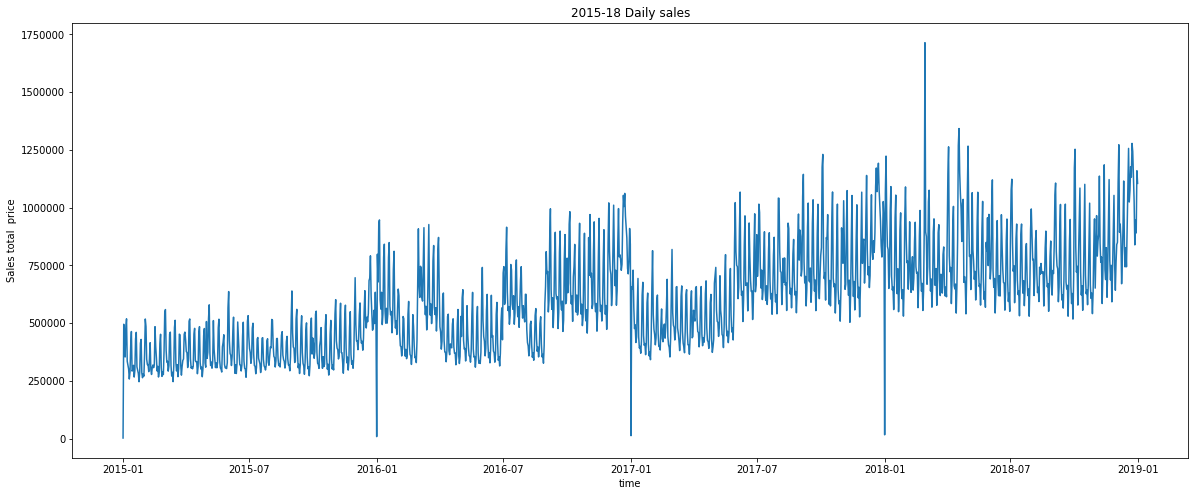

In [38]:
ts=full_data.loc[0:1456].set_index('date')
plt.figure(figsize=(20,8))
plt.title('2015-18 Daily sales')
plt.xlabel('time')
plt.ylabel('Sales total  price')
plt.plot(ts);

Inference : Above figure shows the graph of comple data that has been provided, considering the sum of unit sales per day. There is a trend and seasonality observed. Sudden dip in the sales are observed in the year end.

In [0]:
full_data.to_csv("full_data.csv")

In [39]:
trace0 =  go.Box(
    y=full_data["unit_sales"],
    name = 'Unit_Sales',
    marker = dict(
        color = '#AA0505',
    )

)

data = [trace0]
layout = go.Layout(title = "Boxplot of Unit Sale")
fig = go.Figure(data= data, layout=layout)
iplot(fig)

In [0]:
from pandas import Series, DataFrame
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling = full_data.rolling(window=3)
    rolling_mean = rolling.mean()

    rolling_std = rolling.std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


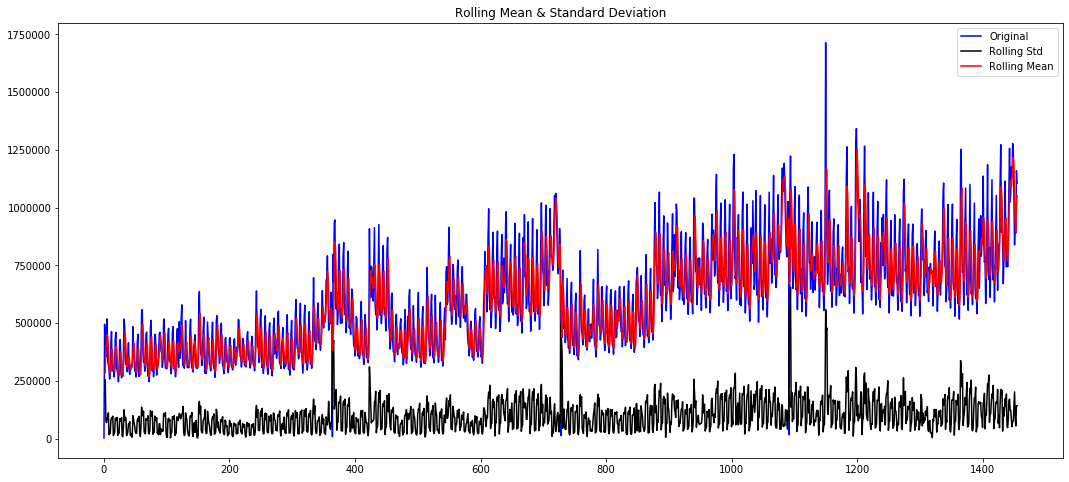

In [41]:
rolling = full_data.rolling(window=3)
rolling_mean = rolling.mean()
rolling_std = rolling.std()
plt.figure(figsize=(18,8))
orig = plt.plot(full_data['unit_sales'], color='blue',label='Original')
#mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

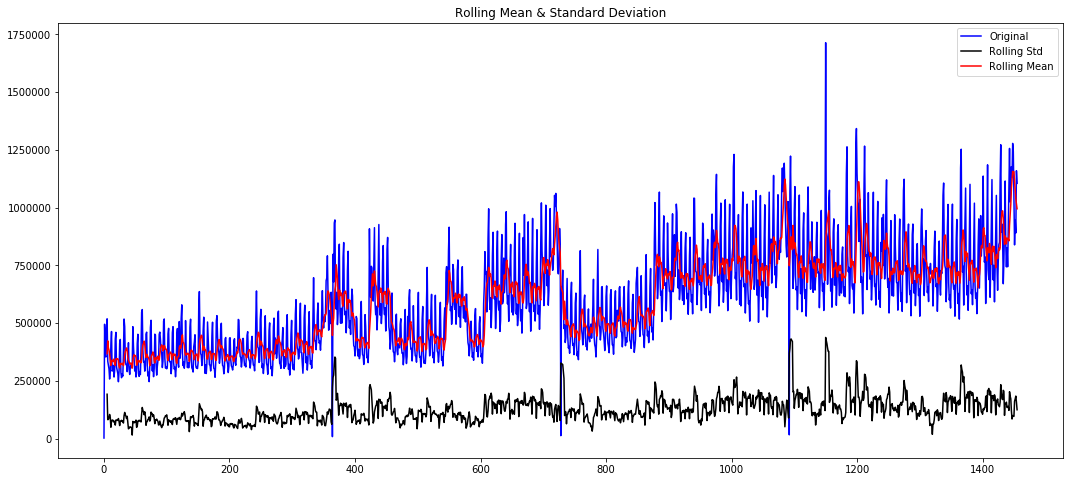

In [43]:
rolling = full_data.rolling(window=6)
rolling_mean = rolling.mean()
rolling_std = rolling.std()
plt.figure(figsize=(18,8))
orig = plt.plot(full_data['unit_sales'], color='blue',label='Original')
#mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Rolling mean and rolling std become smother with the window of 6.

In [44]:
y_hat_avg = full_data[full_data["date"].dt.year > 2017]
y_hat_avg.head

<bound method NDFrame.head of            date  unit_sales
1092 2018-01-01       16361
1093 2018-01-02     1063245
1094 2018-01-03     1223355
1095 2018-01-04      952780
1096 2018-01-05      832068
...         ...         ...
1451 2018-12-27      838866
1452 2018-12-28      947833
1453 2018-12-29      890408
1454 2018-12-30     1159898
1455 2018-12-31     1105355

[364 rows x 2 columns]>

In [0]:
from statsmodels.tsa.holtwinters import Holt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



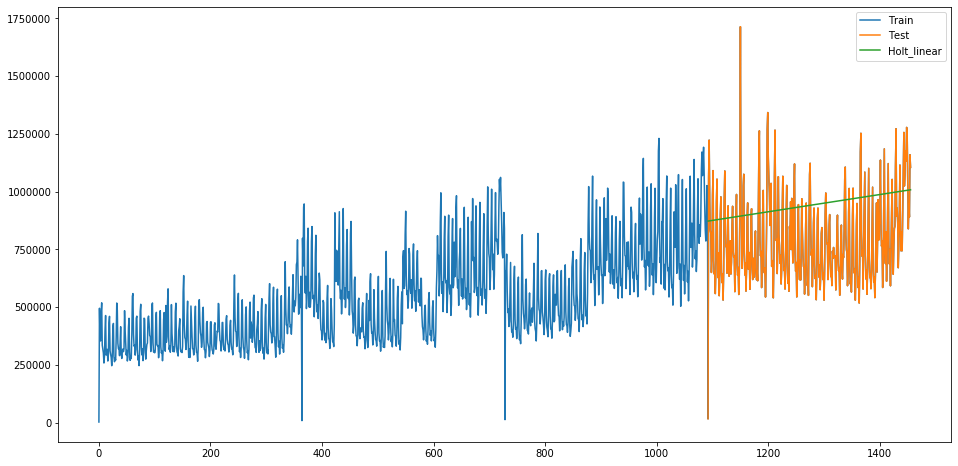

In [46]:
fit1 = Holt(np.asarray(full_data['unit_sales'])).fit(smoothing_level = 0.001,smoothing_slope = 0.0001)
y_hat_avg['Holt_linear'] = fit1.forecast(len(y_hat_avg))

plt.figure(figsize=(16,8))
plt.plot(full_data['unit_sales'], label='Train')
plt.plot(y_hat_avg['unit_sales'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [47]:
mean_absolute_percentage_error(full_data['unit_sales'][1092:,], y_hat_avg['Holt_linear'])

43.665512105156154

By using the Holt linear analysis MAPE is 43.6.

In [0]:
y_hat_avg1 = full_data[full_data["date"].dt.year > 2017]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



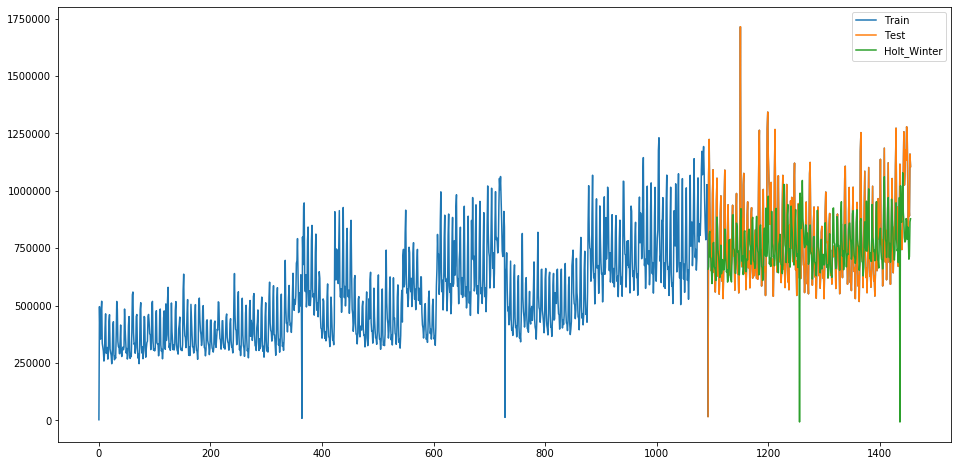

In [49]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(full_data['unit_sales']) ,seasonal_periods=180 ,trend='add', seasonal='mul',).fit()
y_hat_avg1['Holt_Winter'] = fit1.forecast(len(y_hat_avg1))
plt.figure(figsize=(16,8))
plt.plot( full_data['unit_sales'], label='Train')
plt.plot(y_hat_avg1['unit_sales'], label='Test')
plt.plot(y_hat_avg1['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [50]:
mean_absolute_percentage_error(full_data['unit_sales'][1092:,], y_hat_avg1['Holt_Winter'])

27.77693662202844

MAPE is reduced to 27 using Holt winter analysis.

Reading the test file and preprocessing for using.

In [0]:
test_data = pd.read_csv("test.csv")

In [0]:
test_data.isnull().sum()

id             0
date           0
locationId     0
item_id        0
onpromotion    0
dtype: int64

In [0]:
test_data.shape

(1482295, 5)

In [0]:
test_data.dtypes

id              int64
date           object
locationId     object
item_id        object
onpromotion      bool
dtype: object

In [0]:
test_data.head()

,id,date,locationId,item_id,onpromotion
0,0,2019-01-01,location_25,item_99197,False
1,1,2019-01-01,location_25,item_103665,False
2,2,2019-01-01,location_25,item_105574,False
3,3,2019-01-01,location_25,item_105857,False
4,4,2019-01-01,location_25,item_106716,False


In [0]:
test_data.tail()

,id,date,locationId,item_id,onpromotion
1482290,1482290,2019-01-15,location_54,item_2048381,False
1482291,1482291,2019-01-15,location_54,item_2048421,False
1482292,1482292,2019-01-15,location_54,item_2048471,False
1482293,1482293,2019-01-15,location_54,item_2048515,False
1482294,1482294,2019-01-15,location_54,item_2048674,False


In [0]:
test_data['onpromotion'].fillna("Unknown", inplace = True)

In [0]:
test_data_loc_unique = test_data['locationId'].unique()
test_data_item_unique = test_data['item_id'].unique()
test_data_onpromotion_unique = test_data['onpromotion'].unique()

In [0]:
test_data_onpromotion_mapping = {test: idx for 
                                idx, test in 
                                enumerate(test_data_onpromotion_unique, 1)}
test_data['onpromotion'] = test_data['onpromotion'].map(test_data_onpromotion_mapping)

In [0]:
test_data_item_mapping = {test: idx for 
                         idx, test in 
                         enumerate(test_data_item_unique, 1)}
test_data['item_id'] = test_data['item_id'].map(test_data_item_mapping)

In [0]:
test_data_loc_mapping = {test: idx for 
                        idx, test in 
                        enumerate(test_data_loc_unique, 1)}
test_data['locationId'] = test_data['locationId'].map(test_data_loc_mapping)

In [0]:
test_data1 = test_data

Retaining a copy for future usage.

In [0]:
test_data.sort_values(by='date', ascending=True, inplace = True)

In [49]:
test_data.head()

,id,date,locationId,item_id,onpromotion
0,0,2019-01-01,1,1,1
1135,1135,2019-01-01,1,1136,1
1134,1134,2019-01-01,1,1135,1
1133,1133,2019-01-01,1,1134,1
1132,1132,2019-01-01,1,1133,2


In [59]:
test_data.tail()

,id,date,locationId,item_id,onpromotion
1482290,1482290,2019-01-15,53,1687,1
1482291,1482291,2019-01-15,53,3638,1
1482292,1482292,2019-01-15,53,2908,1
1482293,1482293,2019-01-15,53,1689,1
1482294,1482294,2019-01-15,53,3639,1


In [60]:
test_data.dtypes

id              int64
date           object
locationId      int64
item_id         int64
onpromotion     int64
dtype: object

In [61]:
test_data["date"].dtype

dtype('O')

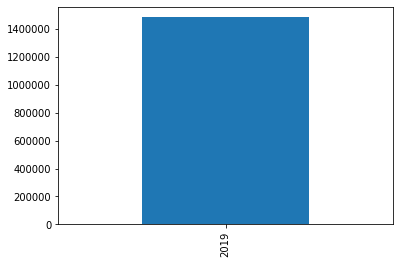

In [62]:
test_data["date"] =  pd.to_datetime(test_data["date"])
test_data["date"].dt.year.value_counts(sort = False).plot.bar()

In [0]:
y_hat_avg2 = test_data["date"].drop_duplicates() 
y_hat_avg2 = y_hat_avg2.astype("datetime64[ns]")


In [64]:
y_hat_avg2

0         2019-01-01
1693      2019-01-02
115918    2019-01-03
225925    2019-01-04
332572    2019-01-05
434787    2019-01-06
537439    2019-01-07
648926    2019-01-08
760179    2019-01-09
862256    2019-01-10
962702    2019-01-11
1062919   2019-01-12
1159555   2019-01-13
1260101   2019-01-14
1370510   2019-01-15
Name: date, dtype: datetime64[ns]

In [65]:
y_hat_avg2.dtypes

dtype('<M8[ns]')

In [0]:
test_data["date"].dtypes

In [0]:
#y_hat_avg2["date"] =  pd.to_datetime(y_hat_avg2["date"])
#y_hat_avg2["date"]  = np.vectorize(pd.Timestamp)(y_hat_avg2["date"][:])

In [67]:
y_hat_avg2.shape

(15,)

In [68]:
full_data.dtypes

date          datetime64[ns]
unit_sales             int32
dtype: object

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



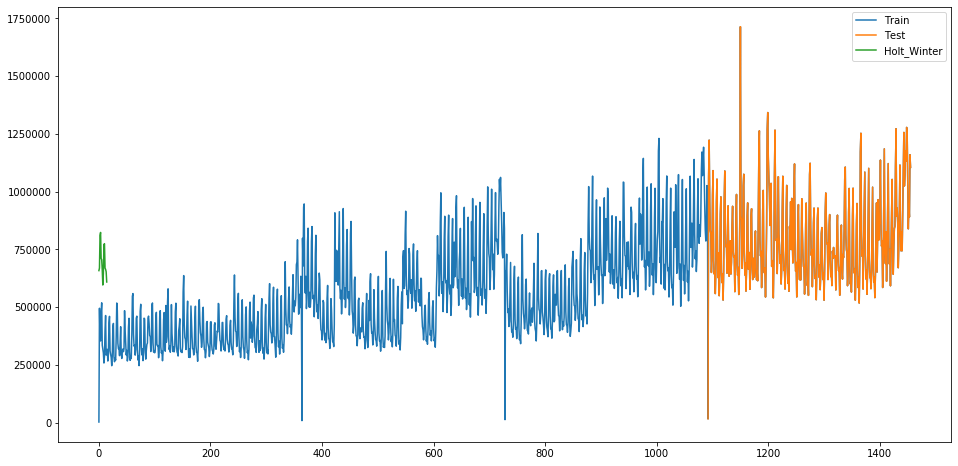

In [69]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(full_data['unit_sales']) ,seasonal_periods=180 ,trend='add', seasonal='mul',).fit()
y_hat_avg2['Holt_Winter'] = fit1.forecast(len(y_hat_avg2))
plt.figure(figsize=(16,8))
plt.plot( full_data['unit_sales'], label='Train')
plt.plot(y_hat_avg1['unit_sales'], label='Test')
plt.plot(y_hat_avg2['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [0]:
full_data.dtypes

In [0]:
full_data['locationId'] = full_data['locationId'].astype("Categorical")
#full_data['item_id'] = full_data['item_id'].astype("Categorical")

In [0]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(full_data['unit_sales','locationId','item_id']) ,seasonal_periods=180 ,trend='add', seasonal='mul',).fit()
y_hat_avg2['Holt_Winter'] = fit1.forecast(len(y_hat_avg2))
plt.figure(figsize=(16,8))
plt.plot( full_data['unit_sales'], label='Train')
plt.plot(y_hat_avg1['unit_sales'], label='Test')
plt.plot(y_hat_avg2['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [71]:
y_hat_avg2['Holt_Winter']

array([658161.65535184, 669132.56694179, 810351.47342698, 823448.64189045,
       710634.55120204, 705735.28771027, 661185.84836904, 595761.87347125,
       645610.0005577 , 770457.59407587, 774797.50028828, 669217.69348062,
       663846.68838752, 653242.40842655, 608906.99361982])

Holt_Winter gives the day wise unit sale starting from 2019-Jan-1 to 2019-Jan-15.

# **RandomForest **
2018 data for analysis, since the google collab crashes by including additional data.


In [50]:
train_2018.shape

(35229871, 5)

In [55]:
train_2018.dtypes

date           datetime64[ns]
locationId              int64
item_id                 int64
unit_sales              int32
onpromotion             int64
dtype: object

In [0]:
train_s= train_2018.sample(70000)
#train_s= train_2018[train_2018["date"] < "2018-01-16"]

In [52]:
train_s.shape

(70000, 5)

In [56]:
train_s.dtypes

date           datetime64[ns]
locationId              int64
item_id                 int64
unit_sales              int32
onpromotion             int64
dtype: object

In [57]:
location_details.dtypes

locationId    object
city           int64
state          int64
type           int64
cluster        int64
dtype: object

In [0]:
location_details.rename(columns={'location_id':'locationId'}, inplace=True)

Since the location id of train file and location file are same, renaming location id of location file to location_id.

Merging item and location file with the train file and droping reduntant or unused columns for prediction.

In [0]:
train_s = train_s.merge(location_details, how ='left', on='locationId')

In [64]:
train_s.dtypes

date           datetime64[ns]
locationId              int64
item_id                 int64
unit_sales              int32
onpromotion             int64
city                   object
state                  object
type                   object
cluster                 int64
dtype: object

In [0]:
train_s = train_s.drop(['locationId', 'city', 'state','type'], axis=1)

In [0]:
train_s = train_s.merge(item_details, how ='left', on='item_id')

In [80]:
train_s

,date,item_id,unit_sales,onpromotion,cluster,category_of_item,class,perishable
0,2018-11-19,1497,3,2,5,1,66,0
1,2018-11-09,2208,2,3,9,20,215,0
2,2018-04-11,560,2,2,3,2,53,0
3,2018-03-24,2713,27,2,8,24,257,0
4,2018-07-19,3340,4,2,15,9,167,0
...,...,...,...,...,...,...,...,...
69995,2018-03-25,839,3,3,6,4,111,1
69996,2018-03-22,81,3,2,6,1,7,0
69997,2018-02-04,1114,6,2,6,10,46,1
69998,2018-02-23,2514,1,2,7,1,21,0


In [81]:
train_s.columns

Index(['date', 'item_id', 'unit_sales', 'onpromotion', 'cluster',
       'category_of_item', 'class', 'perishable'],
      dtype='object')

In [82]:
train_s["unit_sales"].max()

5000

In [67]:
train_s["unit_sales"].min()

0

In [0]:
train_s = train_s.drop(['item_id', 'class'], axis=1)

In [0]:
for cols in ['category_of_item', 'onpromotion', 'cluster']:
    train_s[cols] = train_s[cols].astype('category')

In [86]:
train_s.dtypes

date                datetime64[ns]
unit_sales                   int32
onpromotion               category
cluster                   category
category_of_item          category
perishable                   int64
dtype: object

In [0]:
train_s = train_s.drop(['perishable'], axis=1)

In [0]:
cat_Attr = train_s.select_dtypes(include=['category']).columns

In [89]:
cat_Attr

Index(['onpromotion', 'cluster', 'category_of_item'], dtype='object')

In [0]:
train_s = pd.get_dummies(columns=cat_Attr, data=train_s, 
                      prefix=cat_Attr, prefix_sep="_", drop_first=True)

In [73]:
train_s.head(3)

,date,unit_sales,onpromotion_3,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,category_of_item_2,category_of_item_3,category_of_item_4,category_of_item_5,category_of_item_6,category_of_item_7,category_of_item_8,category_of_item_9,category_of_item_10,category_of_item_11,category_of_item_12,category_of_item_13,category_of_item_14,category_of_item_15,category_of_item_16,category_of_item_17,category_of_item_18,category_of_item_19,category_of_item_20,category_of_item_21,category_of_item_22,category_of_item_23,category_of_item_24,category_of_item_25,category_of_item_26,category_of_item_27,category_of_item_28,category_of_item_29,category_of_item_30
0,2018-07-18,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018-09-03,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018-06-08,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
print (train_s.columns, train_s.shape)

Index(['date', 'unit_sales', 'onpromotion_3', 'cluster_2', 'cluster_3',
       'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8',
       'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13',
       'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17',
       'category_of_item_2', 'category_of_item_3', 'category_of_item_4',
       'category_of_item_5', 'category_of_item_6', 'category_of_item_7',
       'category_of_item_8', 'category_of_item_9', 'category_of_item_10',
       'category_of_item_11', 'category_of_item_12', 'category_of_item_13',
       'category_of_item_14', 'category_of_item_15', 'category_of_item_16',
       'category_of_item_17', 'category_of_item_18', 'category_of_item_19',
       'category_of_item_20', 'category_of_item_21', 'category_of_item_22',
       'category_of_item_23', 'category_of_item_24', 'category_of_item_25',
       'category_of_item_26', 'category_of_item_27', 'category_of_item_28',
       'category_of_item_29', 'category_o

In [0]:
train_2018_1.dtypes


date           datetime64[ns]
item_id                 int64
onpromotion          category
unit_sales              int32
cluster              category
dtype: object

In [0]:
y= train_s["unit_sales"]
X= train_s.drop(["unit_sales", "date"], axis = 1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123) 

In [95]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56000, 46)
(14000, 46)
(56000,)
(14000,)


In [96]:
print(type(X))
print(type(y))

print(type(X_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [100]:
print(X_train.shape)
print(X_test.shape)

(56000, 46)
(14000, 46)


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
clf = RandomForestClassifier(n_estimators=10,max_depth=7)
clf.fit(X=X_train, y=y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [78]:
y_pred = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
errors = abs(y_pred - y_train)
print(errors)

48664     1
37360     5
37226     0
68726     6
12606     1
         ..
63206     8
61404    10
17730     2
28030    13
15725     9
Name: unit_sales, Length: 56000, dtype: int32


In [81]:
mean_absolute_percentage_error(y_train, y_pred)

60.88392429738683

In [109]:
print(y_pred_test)

[1 1 1 ... 1 1 1]


In [83]:
clf.feature_importances_

array([0.25411333, 0.01887599, 0.00629457, 0.14151117, 0.01683149,
       0.0240734 , 0.00530893, 0.02493415, 0.01804432, 0.02019639,
       0.00595746, 0.01637802, 0.07942074, 0.0260946 , 0.00724805,
       0.01202616, 0.00975304, 0.00733026, 0.01183633, 0.01412501,
       0.01257356, 0.01124349, 0.01478861, 0.01168133, 0.03056347,
       0.01317508, 0.00373998, 0.00846128, 0.00803118, 0.00202968,
       0.01017146, 0.01372095, 0.01109505, 0.00513291, 0.04016627,
       0.00993422, 0.01065788, 0.00244283, 0.00873082, 0.00977238,
       0.00369004, 0.00882346, 0.00534215, 0.01137605, 0.01230249,
       0.        ])

In [84]:
importances = clf.feature_importances_
indices = np.argsort(importances)
print(indices)

[45 29 37 40 26 33  6 42 10  2 14 17 28 27 38 41 16 39 35 30 36 32 21 43
 23 18 15 44 20 25 31 19 22 11  4  8  1  9  5  7 13 24 34 12  3  0]


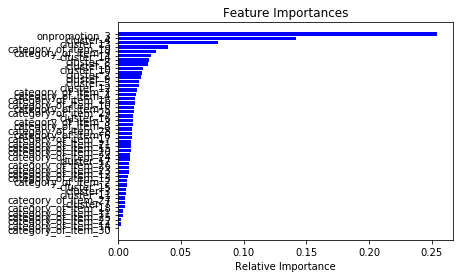

In [85]:

%matplotlib inline
features = X_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [0]:
test_data_rf = test_data1.merge(location_details, how ='left', on='locationId')

In [0]:
test_data_rf = test_data_rf.drop(['locationId', 'city', 'state','type'], axis=1)

In [0]:
test_data_rf = test_data_rf.merge(item_details, how ='left', on='item_id')

In [0]:
test_data_rf = test_data_rf.drop(['item_id', 'class', 'perishable'], axis=1)

In [0]:
for cols in ['category_of_item', 'onpromotion', 'cluster']:
    test_data_rf[cols] = test_data_rf[cols].astype('category')

In [0]:
cat_Attr = test_data_rf.select_dtypes(include=['category']).columns

In [92]:
test_data_rf = pd.get_dummies(columns=cat_Attr, data=test_data_rf, 
                      prefix=cat_Attr, prefix_sep="_", drop_first=True)
print (test_data_rf.columns, test_data_rf.shape)

Index(['id', 'date', 'onpromotion_2', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
       'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14',
       'cluster_15', 'cluster_16', 'cluster_17', 'category_of_item_2',
       'category_of_item_3', 'category_of_item_4', 'category_of_item_5',
       'category_of_item_6', 'category_of_item_7', 'category_of_item_8',
       'category_of_item_9', 'category_of_item_10', 'category_of_item_11',
       'category_of_item_12', 'category_of_item_13', 'category_of_item_14',
       'category_of_item_15', 'category_of_item_16', 'category_of_item_17',
       'category_of_item_18', 'category_of_item_19', 'category_of_item_20',
       'category_of_item_21', 'category_of_item_22', 'category_of_item_23',
       'category_of_item_24', 'category_of_item_25', 'category_of_item_26',
       'category_of_item_27', 'category_of_item_28', 'category_of_item_29',
       'category_of_item_3

In [0]:
test_data_rf= test_data_rf.drop(["date", "id"], axis = 1)

In [130]:
test_data_rf.columns

Index(['onpromotion_2', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10',
       'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15',
       'cluster_16', 'cluster_17', 'category_of_item_2', 'category_of_item_3',
       'category_of_item_4', 'category_of_item_5', 'category_of_item_6',
       'category_of_item_7', 'category_of_item_8', 'category_of_item_9',
       'category_of_item_10', 'category_of_item_11', 'category_of_item_12',
       'category_of_item_13', 'category_of_item_14', 'category_of_item_15',
       'category_of_item_16', 'category_of_item_17', 'category_of_item_18',
       'category_of_item_19', 'category_of_item_20', 'category_of_item_21',
       'category_of_item_22', 'category_of_item_23', 'category_of_item_24',
       'category_of_item_25', 'category_of_item_26', 'category_of_item_27',
       'category_of_item_28', 'category_of_item_29', 'category_of_item_30'],
      dtype='obj

In [0]:
X_test_data_1 = test_data_rf.iloc[0:50000,]

In [132]:
X_test_data_1.shape

(50000, 46)

In [0]:
X_test_data_1.columns

Index(['onpromotion_2', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5',
       'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10',
       'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15',
       'cluster_16', 'cluster_17', 'category_of_item_2', 'category_of_item_3',
       'category_of_item_4', 'category_of_item_5', 'category_of_item_6',
       'category_of_item_7', 'category_of_item_8', 'category_of_item_9',
       'category_of_item_10', 'category_of_item_11', 'category_of_item_12',
       'category_of_item_13', 'category_of_item_14', 'category_of_item_15',
       'category_of_item_16', 'category_of_item_17', 'category_of_item_18',
       'category_of_item_19', 'category_of_item_20', 'category_of_item_21',
       'category_of_item_22', 'category_of_item_23', 'category_of_item_24',
       'category_of_item_25', 'category_of_item_26', 'category_of_item_27',
       'category_of_item_28', 'category_of_item_29', 'category_of_item_30'],
      dtype='obj

In [0]:
1482295/3

494098.3333333333

In [0]:
y_pred_test_data_sub_1 = clf.predict(X_test_data_1)

In [134]:
y_pred_test_data_sub_1

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [135]:
y_pred_test_data_sub_1.max()

20

In [0]:
X_test_data_2 = test_data_rf.iloc[50000:100000,]
X_test_data_3 = test_data_rf.iloc[100000:200000,]
X_test_data_4 = test_data_rf.iloc[200000:300000,]
X_test_data_5 = test_data_rf.iloc[300000:400000,]
X_test_data_6 = test_data_rf.iloc[400000:500000,]
X_test_data_7 = test_data_rf.iloc[500000:600000,]
X_test_data_8 = test_data_rf.iloc[600000:700000,]
X_test_data_9 = test_data_rf.iloc[700000:800000,]
X_test_data_10 = test_data_rf.iloc[800000:900000,]
X_test_data_11 = test_data_rf.iloc[900000:1000000,]
X_test_data_12 = test_data_rf.iloc[1000000:1100000,]
X_test_data_13 = test_data_rf.iloc[1100000:1200000,]
X_test_data_14 = test_data_rf.iloc[1200000:1300000,]
X_test_data_15 = test_data_rf.iloc[1300000:1400000,]
X_test_data_16 = test_data_rf.iloc[1400000:1482295,]

In [0]:
y_pred_test_data_sub_2 = clf.predict(X_test_data_2)

In [0]:

y_pred_test_data_sub_3 = clf.predict(X_test_data_3)
y_pred_test_data_sub_4 = clf.predict(X_test_data_4)
y_pred_test_data_sub_5 = clf.predict(X_test_data_5)
y_pred_test_data_sub_6 = clf.predict(X_test_data_6)
y_pred_test_data_sub_7 = clf.predict(X_test_data_7)
y_pred_test_data_sub_8 = clf.predict(X_test_data_8)
y_pred_test_data_sub_9 = clf.predict(X_test_data_9)
y_pred_test_data_sub_10 = clf.predict(X_test_data_10)
y_pred_test_data_sub_11 = clf.predict(X_test_data_11)
y_pred_test_data_sub_12 = clf.predict(X_test_data_12)
y_pred_test_data_sub_13 = clf.predict(X_test_data_13)
y_pred_test_data_sub_14 = clf.predict(X_test_data_14)
y_pred_test_data_sub_15 = clf.predict(X_test_data_15)
y_pred_test_data_sub_16 = clf.predict(X_test_data_16)


In [0]:
test_pred = np.append(y_pred_test_data_sub_1, y_pred_test_data_sub_2)

In [156]:
test_pred.shape

(100000,)

In [100]:
test_pred = np.append(test_pred, y_pred_test_data_sub_3)
print(test_pred.shape)

(200000,)


In [101]:
test_pred = np.append(test_pred, y_pred_test_data_sub_4)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_5)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_6)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_7)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_8)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_9)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_10)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_11)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_12)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_13)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_14)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_15)
print(test_pred.shape)
test_pred = np.append(test_pred, y_pred_test_data_sub_16)
print(test_pred.shape)

(300000,)
(400000,)
(500000,)
(600000,)
(700000,)
(800000,)
(900000,)
(1000000,)
(1100000,)
(1200000,)
(1300000,)
(1400000,)
(1482295,)


In [102]:
test_data_rf.shape

(1482295, 46)

In [0]:
sub_file = pd.read_csv("sample_submission.csv")

In [161]:
sub_file.columns

Index(['id', 'unit_sales'], dtype='object')

In [0]:
sub_file['unit_sales'] = test_pred

In [105]:
sub_file.head

<bound method NDFrame.head of               id  unit_sales
0              0           1
1              1           1
2              2           1
3              3           1
4              4           1
...          ...         ...
1482290  1482290           1
1482291  1482291           1
1482292  1482292           1
1482293  1482293           1
1482294  1482294           1

[1482295 rows x 2 columns]>

In [0]:
test_data["unit_sales"] = test_pred

In [167]:
test_data.head

<bound method NDFrame.head of               id        date  locationId  item_id  onpromotion  unit_sales
0              0  2019-01-01           1        1            1           1
1              1  2019-01-01           1        2            1           1
2              2  2019-01-01           1        3            1           1
3              3  2019-01-01           1        4            1           1
4              4  2019-01-01           1        5            1           1
...          ...         ...         ...      ...          ...         ...
1482290  1482290  2019-01-15          53     1687            1           1
1482291  1482291  2019-01-15          53     3638            1           1
1482292  1482292  2019-01-15          53     2908            1           2
1482293  1482293  2019-01-15          53     1689            1           1
1482294  1482294  2019-01-15          53     3639            1           1

[1482295 rows x 6 columns]>

In [0]:
test_data_day = test_data.groupby('date').unit_sales.sum().reset_index()

In [180]:
test_data_day.shape

(15, 2)

In [181]:
test_data_day.head

<bound method NDFrame.head of           date  unit_sales
0   2019-01-01        1699
1   2019-01-02      115665
2   2019-01-03      111558
3   2019-01-04      109710
4   2019-01-05      103424
5   2019-01-06      104734
6   2019-01-07      113053
7   2019-01-08      112708
8   2019-01-09      103532
9   2019-01-10      102052
10  2019-01-11      102538
11  2019-01-12       97950
12  2019-01-13      102707
13  2019-01-14      111953
14  2019-01-15      113379>

Graph of 01-Jan-19 to 15-Jan-19 daily prediction

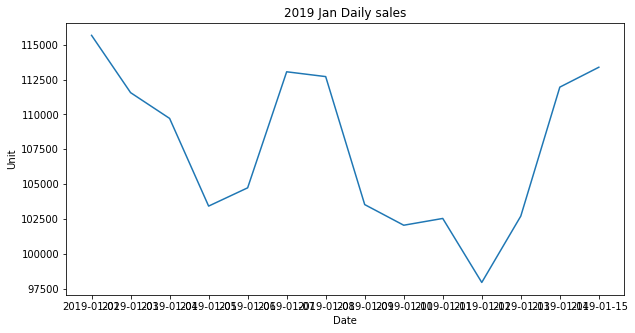

In [186]:
ts=test_data_day.loc[1:15].set_index('date')
plt.figure(figsize=(10,5))
plt.title('2019 Jan Daily sales')
plt.xlabel('Date')
plt.ylabel('Unit')
plt.plot(ts);

In [187]:
test_data.dtypes

id              int64
date           object
locationId      int64
item_id         int64
onpromotion     int64
unit_sales      int32
dtype: object

In [0]:
test_data_loc = test_data.groupby('locationId').unit_sales.sum().reset_index()

In [189]:
test_data_loc.shape

(53, 2)

In [193]:
test_data_loc.head

<bound method NDFrame.head of     locationId  unit_sales
0            1       26656
1            2       29082
2            3       33804
3            4       38483
4            5       33508
5            6       29356
6            7       35370
7            8       33514
8            9       37214
9           10       32166
10          11       19049
11          12       30218
12          13       22450
13          14       19773
14          15       21445
15          16       21933
16          17       19728
17          18       25814
18          19       29295
19          20       21118
20          21       28969
21          22       28530
22          23       20958
23          24       25956
24          25       31860
25          26       19520
26          27       29645
27          28       27404
28          29       27526
29          30       17652
30          31       26723
31          32       14807
32          33       21306
33          34       25822
34          35       1552

In [191]:
test_data_loc.columns

Index(['locationId', 'unit_sales'], dtype='object')

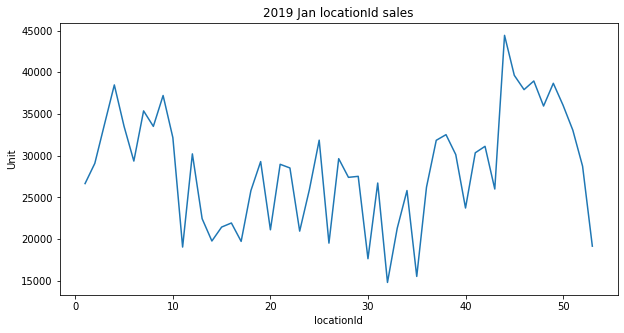

In [190]:
ts=test_data_loc.loc[0:53].set_index('locationId')
plt.figure(figsize=(10,5))
plt.title('2019 Jan locationId sales')
plt.xlabel('locationId')
plt.ylabel('Unit')
plt.plot(ts);

Location id 44 has the maximun sales. 



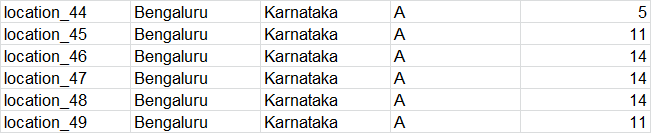

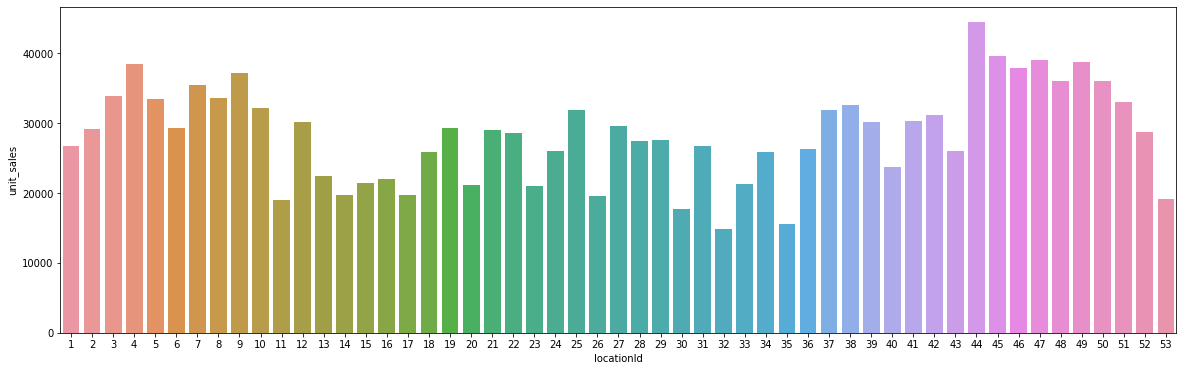

In [196]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
ax = sns.barplot(x="locationId",y = "unit_sales" , data=test_data_loc)

In [0]:
test_data_item_id = test_data.groupby('item_id').unit_sales.sum().reset_index()

In [202]:
test_data_item_id.shape

(3828, 2)

In [0]:
test_data_item_id = test_data_item_id.sort_values(by ='unit_sales',ascending=False )

In [208]:
test_data_item_id.head(10)

,item_id,unit_sales
1944,1945,1512
1936,1937,1387
1951,1952,1317
2855,2856,957
817,818,914
1622,1623,909
1935,1936,897
1537,1538,895
3111,3112,883
1735,1736,848


## **Top selling items**

Unit sale	item				category

- 1512 -->   'item_1239861': 1945	--> vegetables

- 1387 -- >  'item_1239853': 1937	--> vegetables

- 1317 -->    'item_1239875': 1952 -->	vegetables

- 957  -->    'item_1576324': 2856 -->	home_party_utilities

- 914	--> 	'item_661582': 818	-->	other_bevrages

- 909	--> 	'item_1109173': 1623 -->	grocery_items_2

- 897	-- >	'item_1239852': 1936 -->	vegetables

- 895	--> 	'item_1080001': 1538 -->	other_bevrages

- 883	--> 	'item_1913463': 3112 -->	other_farm_produce

- 848	--> 	'item_1158705': 1736 -->	beauty_products

In [216]:
print(itemid_mapping)

{'item_96995': 1, 'item_99197': 2, 'item_103501': 3, 'item_103520': 4, 'item_103665': 5, 'item_105574': 6, 'item_105575': 7, 'item_105576': 8, 'item_105577': 9, 'item_105693': 10, 'item_105737': 11, 'item_105857': 12, 'item_106716': 13, 'item_108079': 14, 'item_108634': 15, 'item_108696': 16, 'item_108698': 17, 'item_108701': 18, 'item_108786': 19, 'item_108797': 20, 'item_108831': 21, 'item_108833': 22, 'item_108862': 23, 'item_108952': 24, 'item_111223': 25, 'item_111397': 26, 'item_112830': 27, 'item_114778': 28, 'item_114790': 29, 'item_114799': 30, 'item_114800': 31, 'item_115267': 32, 'item_115611': 33, 'item_115693': 34, 'item_115720': 35, 'item_115847': 36, 'item_115850': 37, 'item_115891': 38, 'item_115892': 39, 'item_115893': 40, 'item_115894': 41, 'item_116017': 42, 'item_116018': 43, 'item_116279': 44, 'item_116311': 45, 'item_119023': 46, 'item_119024': 47, 'item_119026': 48, 'item_119141': 49, 'item_119187': 50, 'item_119191': 51, 'item_119193': 52, 'item_119624': 53, 'it

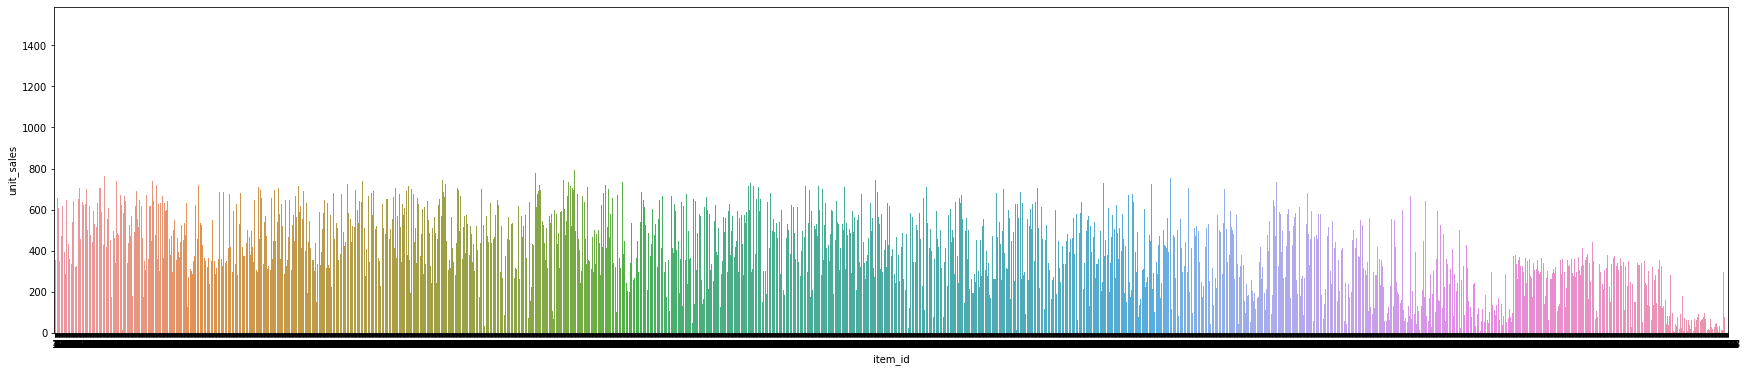

In [209]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 6)
ax = sns.barplot(x="item_id",y = "unit_sales" , data=test_data_item_id)

In [0]:
test_data_loc_cat = test_data.merge(location_details, how ='left', on='locationId')

In [109]:
test_data_loc_cat.dtypes

id              int64
date           object
locationId      int64
item_id         int64
onpromotion     int64
unit_sales      int32
city           object
state          object
type           object
cluster         int64
dtype: object

In [0]:
test_data_loc_cat.drop(['onpromotion', 'id','date', 'state' ,], axis=1, inplace = True)

In [116]:
test_data_loc_cat.dtypes

locationId     int64
item_id        int64
unit_sales     int32
city          object
type          object
cluster        int64
dtype: object

In [0]:
test_cluster = test_data_loc_cat.groupby('cluster').unit_sales.sum().reset_index()

In [123]:
test_cluster.head(10)


,cluster,unit_sales
0,1,87461
1,2,63221
2,3,114888
3,4,98366
4,5,42651
5,6,162334
6,7,46512
7,8,103592
8,9,60489
9,10,152088


In [0]:
test_cluster1 = test_cluster.sort_values(by ='unit_sales',ascending=False )

In [125]:
test_cluster1.head(10)

,cluster,unit_sales
5,6,162334
9,10,152088
13,14,149895
14,15,130682
2,3,114888
10,11,106930
7,8,103592
12,13,102215
3,4,98366
0,1,87461


Cluster 6 has the highest selling items.

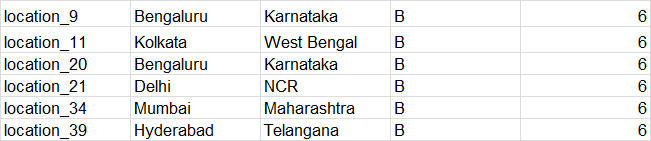

In [0]:
test_cluster_item = test_data_loc_cat.groupby(['cluster', 'item_id']).unit_sales.sum().reset_index()

In [129]:
test_cluster_item.head

<bound method NDFrame.head of        cluster  item_id  unit_sales
0            1        1          11
1            1        2          37
2            1        3          40
3            1        4          14
4            1        5          25
...        ...      ...         ...
53815       17     3817           4
53816       17     3818           2
53817       17     3819           7
53818       17     3820           5
53819       17     3826           1

[53820 rows x 3 columns]>

In [0]:
test_cluster_item_sale = test_cluster_item[test_cluster_item["cluster"] == 6]

In [132]:
test_cluster_item_sale.head

<bound method NDFrame.head of        cluster  item_id  unit_sales
15762        6        1           8
15763        6        2          48
15764        6        3          14
15765        6        4          61
15766        6        5          81
...        ...      ...         ...
19520        6     3824           1
19521        6     3825           4
19522        6     3826           4
19523        6     3827           1
19524        6     3828           4

[3763 rows x 3 columns]>

In [133]:
test_cluster_item_sale.groupby(['item_id']).unit_sales.sum().reset_index()

,item_id,unit_sales
0,1,8
1,2,48
2,3,14
3,4,61
4,5,81
...,...,...
3758,3824,1
3759,3825,4
3760,3826,4
3761,3827,1


In [0]:
test_cluster_item_sale = test_cluster_item_sale.sort_values(by ='unit_sales',ascending=False )

In [135]:
test_cluster_item_sale.head(10)

,cluster,item_id,unit_sales
16369,6,608,100
18585,6,2837,97
15959,6,198,88
18582,6,2834,86
16467,6,706,84
15925,6,164,84
16980,6,1220,84
15922,6,161,84
15813,6,52,84
15867,6,106,84


Top ten selling item id in the cluster 6

16369	6	608		100 'item_514444': 608	other_utilities

18585	6	2837	97   'item_1575240': 2837	home_utilities_4

15959	6	198		88	'item_250782': 198		home_utilities

18582	6	2834	86	'item_1575235': 2834

16467	6	706		84	'item_582863': 706

15925	6	164		84	'item_214862': 164

16980	6	1220	84	'item_895291': 1220

15922	6	161		84	'item_214381': 161

15813	6	52		84	'item_119193': 52

15867	6	106		84	'item_165718': 106

In [136]:
test_cluster_item_sale.head

<bound method NDFrame.head of        cluster  item_id  unit_sales
16369        6      608         100
18585        6     2837          97
15959        6      198          88
18582        6     2834          86
16467        6      706          84
...        ...      ...         ...
19496        6     3788           1
19497        6     3790           1
19006        6     3263           1
19463        6     3737           1
18628        6     2880           1

[3763 rows x 3 columns]>

In [0]:
test_item_week = test_data.groupby(['date','item_id']).unit_sales.sum().reset_index()

In [138]:
test_item_week.head

<bound method NDFrame.head of              date  item_id  unit_sales
0      2019-01-01        1           1
1      2019-01-01        2           1
2      2019-01-01        3           1
3      2019-01-01        4           1
4      2019-01-01        5           1
...           ...      ...         ...
54731  2019-01-15     3819          12
54732  2019-01-15     3820          15
54733  2019-01-15     3825           1
54734  2019-01-15     3826          24
54735  2019-01-15     3828          16

[54736 rows x 3 columns]>

In [0]:
test_item_week1 = test_item_week[test_item_week['date'] < "2019-01-07"]

In [0]:
w1 = test_item_week1.groupby(['item_id']).unit_sales.sum().reset_index()

In [0]:
w1 = w1.sort_values(by ='unit_sales',ascending=False )

In [143]:
w1

,item_id,unit_sales
998,999,393
1630,1631,365
880,881,361
749,750,344
869,870,317
...,...,...
3817,3818,2
3806,3807,1
3808,3809,1
3726,3727,1


In [0]:
gr1 = test_data.groupby(['item_id', 'date']).unit_sales.sum().reset_index()

In [148]:
gr1.head

<bound method NDFrame.head of        item_id        date  unit_sales
0            1  2019-01-01           1
1            1  2019-01-02          15
2            1  2019-01-03          14
3            1  2019-01-04          15
4            1  2019-01-05          12
...        ...         ...         ...
54731     3826  2019-01-14          11
54732     3826  2019-01-15          24
54733     3827  2019-01-13           1
54734     3828  2019-01-14           2
54735     3828  2019-01-15          16

[54736 rows x 3 columns]>

In [0]:
gr2 = gr1.sort_values(by ='date',ascending=True )

In [151]:
gr2

,item_id,date,unit_sales
0,1,2019-01-01,1
24521,1637,2019-01-01,1
11859,792,2019-01-01,1
24506,1636,2019-01-01,1
24491,1635,2019-01-01,1
...,...,...,...
29697,2002,2019-01-15,36
9788,653,2019-01-15,32
29683,2001,2019-01-15,50
51752,3587,2019-01-15,21


In [0]:
gr3 = gr2.groupby([ 'date', 'item_id']).unit_sales.sum().reset_index()

In [153]:
gr3

,date,item_id,unit_sales
0,2019-01-01,1,1
1,2019-01-01,2,1
2,2019-01-01,3,1
3,2019-01-01,4,1
4,2019-01-01,5,1
...,...,...,...
54731,2019-01-15,3819,12
54732,2019-01-15,3820,15
54733,2019-01-15,3825,1
54734,2019-01-15,3826,24


In [0]:
mean_absolute_percentage_error(y_train, y_pred)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in true_divide



inf

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

rfc = RandomForestClassifier(n_jobs=-1, max_features='sqrt') 
 
# Use a grid over parameters of interest
param_grid = { 
           "max_depth" : [2,3,5],
           "min_samples_leaf" : [2, 4]}

scores = ['precision', 'recall']

In [0]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print("\n")

    clf = GridSearchCV(estimator=rfc, param_grid=param_grid,cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on training set:")
    print("\n")
    print(clf.best_params_)
    print("\n")
    
    print("Grid scores on training set:")
    print("\n")
    means = clf.cv_results_['mean_test_score']
    for mean, params in zip(means, clf.cv_results_['params']):
        print("%0.3f for %r"
              % (mean, params))

# Tuning hyper-parameters for precision




/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedM

Best parameters set found on training set:


{'max_depth': 5, 'min_samples_leaf': 4}


Grid scores on training set:


0.001 for {'max_depth': 2, 'min_samples_leaf': 2}
0.001 for {'max_depth': 2, 'min_samples_leaf': 4}
0.002 for {'max_depth': 3, 'min_samples_leaf': 2}
0.001 for {'max_depth': 3, 'min_samples_leaf': 4}
0.002 for {'max_depth': 5, 'min_samples_leaf': 2}
0.002 for {'max_depth': 5, 'min_samples_leaf': 4}
# Tuning hyper-parameters for recall




/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Best parameters set found on training set:


{'max_depth': 5, 'min_samples_leaf': 4}


Grid scores on training set:


0.006 for {'max_depth': 2, 'min_samples_leaf': 2}
0.006 for {'max_depth': 2, 'min_samples_leaf': 4}
0.006 for {'max_depth': 3, 'min_samples_leaf': 2}
0.006 for {'max_depth': 3, 'min_samples_leaf': 4}
0.006 for {'max_depth': 5, 'min_samples_leaf': 2}
0.006 for {'max_depth': 5, 'min_samples_leaf': 4}
